# Libraries

In [1]:
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Loading the Data

In [5]:
train_df = pd.read_csv("train.csv")  # Contains image names and labels
test_df = pd.read_csv("test.csv")    # Contains image names for prediction

# View the data
print("Training Data Head")
print(train_df.head())
print("\n")
print("\n Testing Data Head")
print(test_df.head())

Training Data Head
  Image_name  Emotion
0  63119.png    happy
1  61769.png  neutral
2  95472.png  disgust
3  93515.png  neutral
4  56585.png    angry



 Testing Data Head
  Image_name
0  84757.png
1  57211.png
2  28038.png
3  16408.png
4  43196.png


# Data Preprocessing

### Loading and Visualizing Images

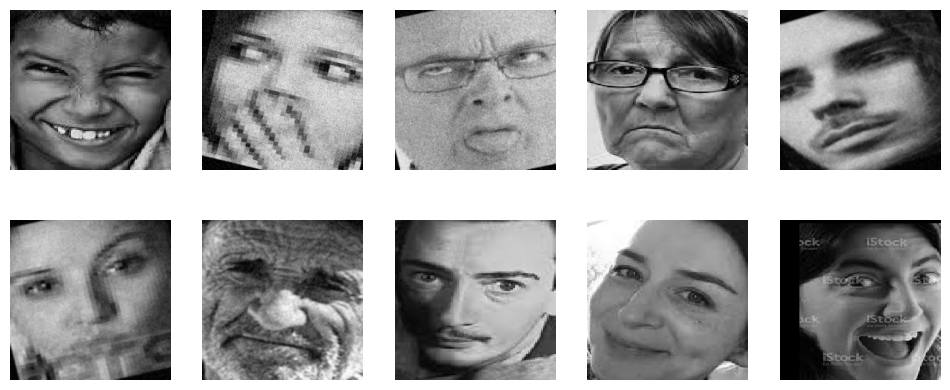

In [9]:
# Function to load an image
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return img

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, img_name in enumerate(train_df['Image_name'].sample(10, random_state=42)):
    img = load_image(os.path.join("Images", img_name))  # Update path if needed
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis("off")
plt.show()


### Loading and Visualizing Images

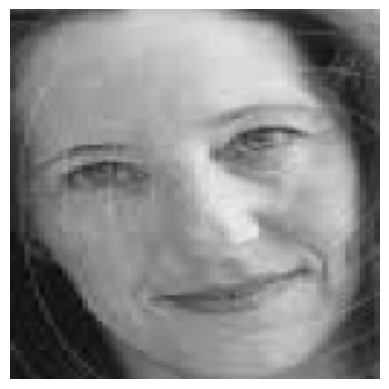

In [10]:
IMG_SIZE = 128  # Resize all images to 128x128

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalize
    return img

# Example usage
sample_image = preprocess_image(os.path.join("Images", train_df['Image_name'][0]))
plt.imshow(sample_image)
plt.axis("off")
plt.show()


# Model Development

### Pretrained Model

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load EfficientNetB0
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_df['Emotion'].unique()), activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 14,669,227 (55.96 MB)

 Trainable params: 10,619,656 (40.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Custom CNN Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_df['Emotion'].unique()), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Training the Model


In [22]:
missing_images = [img for img in train_df['Image_name'] if not os.path.exists(os.path.join("Images", img))]
print(f"Missing Images: {len(missing_images)}")


Missing Images: 0


In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

# -------------------------------
# Constants and Configurations
# -------------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10  # Train only the custom head first
EPOCHS_PHASE2 = 20  # Then fine-tune part of the base model

# -------------------------------
# Load and Preprocess Data
# -------------------------------
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Encode emotion labels to integers
label_encoder = LabelEncoder()
train_df['emotion'] = label_encoder.fit_transform(train_df['Emotion'])

# Create full image paths
train_df["image_path"] = train_df["Image_name"].apply(lambda x: os.path.join("Images", x))
test_df["image_path"] = test_df["Image_name"].apply(lambda x: os.path.join("Images", x))

# Function to verify image validity
def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Check integrity
        return True
    except Exception:
        return False

# Check that images exist and are valid
train_df["exists"] = train_df["image_path"].apply(lambda x: os.path.exists(x) and is_valid_image(x))
test_df["exists"] = test_df["image_path"].apply(lambda x: os.path.exists(x) and is_valid_image(x))
print("Corrupt or Missing Train Images:", train_df[~train_df["exists"]].shape[0])
print("Corrupt or Missing Test Images:", test_df[~test_df["exists"]].shape[0])
train_df = train_df[train_df["exists"]].reset_index(drop=True)
test_df = test_df[test_df["exists"]].reset_index(drop=True)

# -------------------------------
# Data Augmentation with Proper Preprocessing
# -------------------------------
# Use EfficientNet's preprocess_input to scale images to [-1, 1]
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    validation_split=0.2
)

# Generators for Phase 1
train_generator_phase1 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="emotion",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="training",
    shuffle=True
)

val_generator_phase1 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="emotion",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation",
    shuffle=False
)

# -------------------------------
# Build the Model (Phase 1: Train the Head)
# -------------------------------
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the entire base model initially

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(len(train_df['emotion'].unique()), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile Phase 1 model with a higher learning rate for the head
optimizer_phase1 = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer_phase1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for Phase 1
callbacks_phase1 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint("Emotion_model_phase1_best.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
]

# Compute class weights to handle any imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['emotion']), y=train_df['emotion'])
class_weights_dict = dict(enumerate(class_weights))

# Train Phase 1
history_phase1 = model.fit(
    train_generator_phase1,
    validation_data=val_generator_phase1,
    epochs=EPOCHS_PHASE1,
    class_weight=class_weights_dict,
    callbacks=callbacks_phase1
)

# -------------------------------
# Phase 2: Fine-Tuning the Base Model
# -------------------------------
# Unfreeze the last 20 layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
optimizer_phase2 = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer_phase2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for Phase 2
callbacks_phase2 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint("Emotion_model_phase2_best.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
]

# Continue training (Phase 2) using the same generators
history_phase2 = model.fit(
    train_generator_phase1,
    validation_data=val_generator_phase1,
    epochs=EPOCHS_PHASE2,
    class_weight=class_weights_dict,
    callbacks=callbacks_phase2
)

# Save the final model
model.save("Emotion_model_final.keras")
print("Model saved successfully!")

Corrupt or Missing Train Images: 1
Corrupt or Missing Test Images: 0
Found 5681 validated image filenames.
Found 1420 validated image filenames.


c:\Users\SHASHANK\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.2247 - loss: 2.5293
Epoch 1: val_accuracy improved from -inf to 0.27817, saving model to Emotion_model_phase1_best.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.2248 - loss: 2.5282 - val_accuracy: 0.2782 - val_loss: 1.8142 - learning_rate: 0.0010
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.2890 - loss: 2.0070
Epoch 2: val_accuracy improved from 0.27817 to 0.35000, saving model to Emotion_model_phase1_best.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.2890 - loss: 2.0068 - val_accuracy: 0.3500 - val_loss: 1.6975 - learning_rate: 0.0010
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.3381 - loss: 1.8647
Epoch 3: val_accuracy improved from 0.35000 to 0.39225, saving model to Emotion_model_phase1_best.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.3381 - loss: 1.8646 - val_accuracy: 0.3923 - val_loss: 1.6270 - learning_rate: 0.0010
E

In [9]:
# -------------------------------
# Testing & Predictions
# -------------------------------
# For test data, use the same preprocessing function
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)


# Generate predictions and decode to original emotion names
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
test_df["Emotion"] = label_encoder.inverse_transform(predicted_labels)
test_df[[ "Emotion"]].to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Found 3045 validated image filenames.


c:\Users\SHASHANK\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 612ms/step
Submission file saved as submission.csv
